In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fixed_point, root_scalar

In [59]:
def gamma_self_consistency(gamma, k, w, p, D, r, hE2, hE_hI, hI2):
    exp_gamma = np.exp(gamma)
    w_plus = (k-1)*w
    beta_plus = r + w_plus * exp_gamma
    
    # First term
    term1 = (p * D * w * exp_gamma * (r - k * r + 2 * k * w * exp_gamma)) / (r * beta_plus * (2 * r + w_plus * exp_gamma))
    
    # Second term
    term2 = (p / (r**2 * beta_plus**2)) * (
        (r + k * w * exp_gamma) * w * exp_gamma * hE2
        - k * w**2 * (exp_gamma**2) * hE_hI
        - (r - w * exp_gamma) * k * w * exp_gamma * hI2
    )
    
    return term1 + term2

'''
def gamma_self_consistency(gamma, k, w, p, D, r, hE2, hE_hI, hI2):
    numerator = np.exp(gamma) * w * (r - k * r + 2 * np.exp(gamma) * k * w)
    denominator = (4 * r**2 + 4 * np.exp(gamma) * (-1 + k) * r * w + 
                   2 * np.exp(2 * gamma) * (1 + k**2) * w**2)
    return p * numerator / denominator
'''

def covariance(gamma, k, w, p, D, r):
    exp_gamma = np.exp(gamma)
    w_plus = (k-1)*w
    beta_plus = r + w_plus * exp_gamma
    
    return D / (r * beta_plus * (2 * r + w_plus)) * (w * exp_gamma * (r - k * r + 2 * k * w * exp_gamma))

def derivative_f(gamma, k, w, p, D, r, hE2, hE_hI, hI2, eps=1e-6):
    return (gamma_self_consistency(gamma + eps, k, w, p, D, r, hE2, hE_hI, hI2) - gamma_self_consistency(gamma - eps, k, w, p, D, r, hE2, hE_hI, hI2)) / (2 * eps)

In [38]:
derivative_f(0.7, k, w, p, D, r, hE2, hE_hI, hI2)#<1

0.01239016148013583

True
0.09644681803729618 - X stable? True - gamma stable? True
3.11594337860928 - X stable? True - gamma stable? False
4.9691859692841165 - X stable? True - gamma stable? True


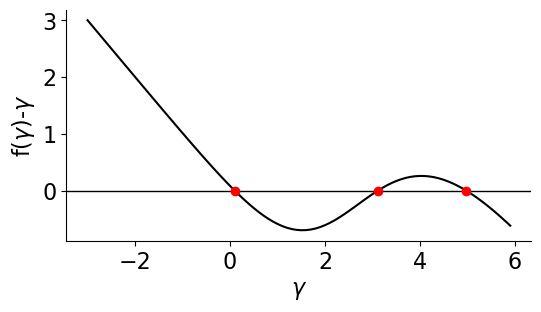

In [68]:
k = 1.1
w = 2.
p = 0.025
r = 1.
D = 1.
hE2 = 0.
hE_hI = 0.
hI2 = 0.

print( k > 1 - r / w )

xx = np.arange(-3,6,0.1)

plt.figure(figsize=(6,3))
plt.plot(xx, gamma_self_consistency(xx, k, w, p, D, r, hE2, hE_hI, hI2) - xx, c='k')
plt.axhline(0, c='k', lw=1)

try:
    fp_1 = fixed_point(gamma_self_consistency, 0, args=(k, w, p, D, r, hE2, hE_hI, hI2), maxiter=int(5e5))
    print(fp_1, '- X stable?', k > 1 - r / w / np.exp(fp_1), '- gamma stable?', derivative_f(fp_1, k, w, p, D, r, hE2, hE_hI, hI2)<1)
    
    plt.scatter(fp_1, gamma_self_consistency(fp_1, k, w, p, D, r, hE2, hE_hI, hI2) - fp_1, c='red', zorder=10)
except:
    pass
    
try:
    fp_2 = fixed_point(gamma_self_consistency, 2.5, args=(k, w, p, D, r, hE2, hE_hI, hI2), maxiter=int(5e5))
    print(fp_2, '- X stable?', k > 1 - r / w / np.exp(fp_2), '- gamma stable?', derivative_f(fp_2, k, w, p, D, r, hE2, hE_hI, hI2)<1)
    
    plt.scatter(fp_2, gamma_self_consistency(fp_2, k, w, p, D, r, hE2, hE_hI, hI2) - fp_2, c='red', zorder=10)
except:
    pass

try:
    fp_3 = fixed_point(gamma_self_consistency, 6., args=(k, w, p, D, r, hE2, hE_hI, hI2), maxiter=int(5e5))
    print(fp_3, '- X stable?', k > 1 - r / w / np.exp(fp_3), '- gamma stable?', derivative_f(fp_3, k, w, p, D, r, hE2, hE_hI, hI2)<1)
    
    plt.scatter(fp_3, gamma_self_consistency(fp_3, k, w, p, D, r, hE2, hE_hI, hI2) - fp_3, c='red', zorder=10)
except:
    pass

#plt.ylim(-0.02, 0.3)

plt.xlabel(r'$\gamma$')
plt.ylabel(r'f($\gamma$)-$\gamma$')
sns.despine()
plt.show()

In [65]:
np.exp(5)

148.4131591025766

In [2]:
from utils.simulation import *
from utils import plotting

In [3]:
def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = .01
    tau_p = 1000.
    p = .025
    r = np.ones(N)
    D = 1.
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r, 'tau_p': tau_p, 'p': p, 'D': D}

In [7]:
### Info input
M = 1 #3
tau_h = 80
wup = 1 / tau_h
wdown = 1 / tau_h
delta_h = .5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(1e6)
dt = 0.0001

### Create info dictionary
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [8]:
info_system = create_info_system(**get_default_params_system())

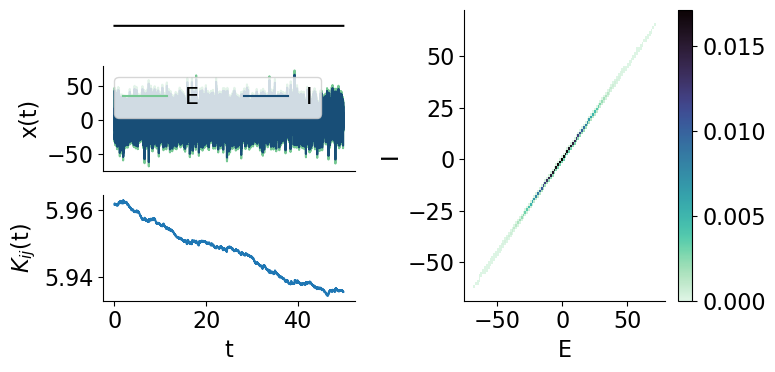

In [9]:
inputs, states = simulate_coupled_system(info_system, info_input, info_simulation, linear=True, seed=None)
states, plasticity = states

plotting.plot_simulation(states, inputs, plasticity, hs[0], dt, max_steps_to_plot = int(5e5))

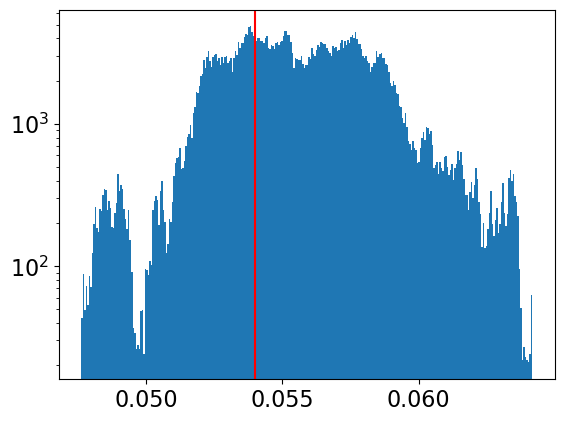

In [51]:
plt.hist(plasticity[-int(5e5):], bins=300)
plt.axvline(0.054003975083638786, c='red')
plt.yscale('log')
plt.show()

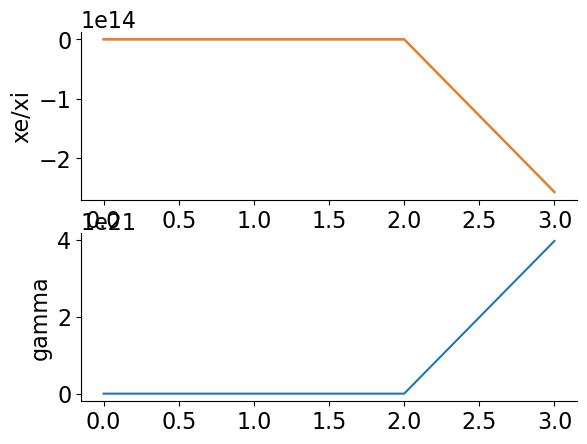

In [12]:
tmax = np.where(np.isnan(states[:,0]))[0][0] -30

plt.subplot(2,1,1)
plt.plot( states[:tmax,:] )
plt.ylabel('xe/xi')

plt.subplot(2,1,2)
plt.plot(plasticity[:tmax])
plt.ylabel('gamma')

sns.despine()
plt.show()

In [109]:
def Jacobian(xe, xi, gamma, w, k, r, p):
    return np.array(([
                    [-r + w*np.exp(gamma), -k*w*np.exp(gamma), w*np.exp(gamma)*(xe - k*xi)],
                    [w*np.exp(gamma), -r-k*w*np.exp(gamma), w*np.exp(gamma)*(xe - k*xi)],
                    [p*xi, p*xe, -1]
    ]))

def fp_dynamics(x, w, k, r, p):
    xe = x[0]
    xi = x[1]
    
    return np.array(([
                    w*np.exp(p*xe*xi) -k*w*np.exp(p*xe*xi),
                    w*np.exp(p*xe*xi) -k*w*np.exp(p*xe*xi),
    ]))

In [110]:
jac_0 = Jacobian(states[tmax,0], states[tmax,1], 0, w, k, r, 0)
jac_1 = Jacobian(states[tmax,0], states[tmax,1], fp_1, w, k, r, p)
jac_2 = Jacobian(states[tmax,0], states[tmax,1], fp_2, w, k,  r, p)

In [111]:
np.linalg.eigvals(jac_0), np.linalg.eigvals(jac_1), np.linalg.eigvals(jac_2)

(array([-0.99999998, -1.00000002, -1.        ]),
 array([ 3.76226607, -1.        , -5.76226607]),
 array([ 11.29786705,  -1.        , -13.29786705]))

In [70]:
fixed_point(fp_dynamics, np.array([1., 0.]), args=(w, k, r, p))

array([0., 0.])

In [59]:
Jacobian(np.array([0., 0., 0.]), w, k, r, p)

TypeError: Jacobian() missing 2 required positional arguments: 'r' and 'p'

In [71]:
- 1 / p * np.log(w*(1 - k))

/tmp/ipykernel_134817/1406209329.py:1: RuntimeWarning: divide by zero encountered in log
  - 1 / p * np.log(w*(1 - k))


inf

In [ ]:
xx = np.arange(-10, 10, 0.1)
xx = np.arange(-10, 10, 0.1)

plt.plot(xx, )